# Final Project: Daily Kos Dataset

### Course: SPS DATA 620 - Web Analytics (Summer 2023 - 7W)

### Professor: Alain Ledon

### Team Members: Coffy Andrews-Guo and Tora Mullings

#### Submission Date: July 17, 2023

#### [Github Source](https://github.com/candrewxs/D620/tree/main/Final_Project)

## Introduction:

This project aims to perform network analysis and text processing on the Daily Kos dataset, a bipartite document-word dataset.

During our research, we discovered that Daily Kos has two repositories: one on Konect and another on the University of California Irvine (UCI) Machine Learning Repository. Observing how a single website can be compiled and shared on various platforms was interesting.

The `Konect` Daily Kos dataset is bipartite and represent the connections between documents and words. Each edge in the network represents the occurrence of a word in a document. More details about the network can be found at http://konect.cc/networks/bag-kos/.

The "bag of words" dataset, found on the `UCI Machine Learning Repository`, comprises five text collections represented as bags-of-words. These collections have no class labels and do not contain filenames or other document-level metadata for copyright reasons. This dataset is perfect for conducting clustering and topic modeling experiments. Each collection has two files: docword.*.txt, consisting of the bag of sparse-formulated words, and vocab.*.txt, which contains the vocabulary. For those interested in accessing this dataset, please visit http://archive.ics.uci.edu/dataset/164/bag+of+words.

## API Data Retrieval Process 

### Required Packages/Libraries

In [2]:
# disable warnings
import warnings 
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
# fundamental packages
import numpy as np
import pandas as pd

#functions creating iterators for efficient looping
import itertools 

# HTTP requests
import requests
# read and write tar archives
import tarfile
# core tool for working with streams and file-like objects
import io
# import and export format for spreadsheets and databases
import csv

# create, manipulate, and study graphs and networks
import networkx as nx
import networkx.algorithms.bipartite as bipartite
#from networkx.algorithms import bipartite

# create static, animated, and interactive visualizations
import nxviz as nv
import matplotlib.pyplot as plt 
%matplotlib inline

### Konect Data

In [4]:
# URL of the TSV zip file
url = "http://konect.cc/files/download.tsv.bag-kos.tar.bz2"

# Send an HTTP GET request to fetch the TSV zip file
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Create a file-like object from the downloaded content
    file_like_object = io.BytesIO(response.content)
    
    # Extract the tar.bz2 file from the file-like object
    with tarfile.open(fileobj=file_like_object, mode="r:bz2") as tar:
        # Get the first file from the extracted contents
        first_file = tar.getmembers()[1]
        
        # Extract the TSV file from the tar archive
        tsv_file = tar.extractfile(first_file)
        
        # Create a reader object for the TSV content
        reader = pd.read_csv(tsv_file, delimiter='\s', engine = 'python')
        
        print(reader.head(10))
else:
    print("Failed to fetch the TSV zip file. Status code:", response.status_code)

   %  bip  positive
0  1    1         2
1  1    2         1
2  1    3         1
3  1    4         1
4  1    5         1
5  1    6         1
6  1    7         1
7  1    8         1
8  1    9         2
9  1   10         1


### University of California (UCI) Data

The docword.*txt file format is 3 header lines, followed by NNZ triples:
* D - is the number of documents
* W - is the number of words in the vocabulary
* NNZ - is the number of nonzero counts in the bag-of-words 
* docID wordID count
* ...

In [2]:
!curl http://archive.ics.uci.edu/ml/machine-learning-databases/bag-of-words/docword.kos.txt.gz | gzip -d > docword.kos.txt
!head docword.kos.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  797k    0  797k    0     0   753k      0 --:--:--  0:00:01 --:--:--  754k
100 1029k    0 1029k    0     0   874k      0 --:--:--  0:00:01 --:--:--  875k


3430
6906
353160
1 61 2
1 76 1
1 89 1
1 211 1
1 296 1
1 335 1
1 404 1


The vocab.*.txt file format is line <n> contains wordID=n

In [5]:
!curl http://archive.ics.uci.edu/ml/machine-learning-databases/bag-of-words/vocab.kos.txt > vocab.kos.txt
!head vocab.kos.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 55467    0 55467    0     0   145k      0 --:--:-- --:--:-- --:--:--  147k


aarp
abandon
abandoned
abandoning
abb
abc
abcs
abdullah
ability
aboard


In [6]:
def parse_bag_of_words_file(docword, vocab):
    with open(vocab, "r") as f:
        kos_vocab = [word.strip() for word in f.readlines()]
        id_to_word = {i: word for i, word in enumerate(kos_vocab)}

    with open(docword, "r") as f:
        raw = [list(map(int, _.strip().split())) for _ in f.readlines()][3:]

    docs = []
    for _, grp in itertools.groupby(raw, lambda x: x[0]):
        doc = []
        for _, word_id, word_cnt in grp:
            doc += word_cnt * [id_to_word[word_id-1]]
        docs.append(doc)
    return docs, id_to_word


In [7]:
docs, id_to_word = parse_bag_of_words_file("docword.kos.txt", "vocab.kos.txt")
vocab_size = len(set(word for doc in docs for word in doc))

In [8]:
# Print a range of vocab lines entries
for i in range(1): # Specify the range
    print("Vocabulary Size: ", vocab_size, docs[i])

Vocabulary Size:  6906 ['action', 'action', 'added', 'administration', 'alliances', 'antiwar', 'approve', 'assault', 'attack', 'attitude', 'attitude', 'aug', 'battle', 'believes', 'broad', 'bush', 'bush', 'career', 'chairman', 'click', 'coalition', 'committee', 'committee', 'compared', 'compared', 'conclude', 'conclusion', 'conclusions', 'congressional', 'congressional', 'congressman', 'congressman', 'considered', 'constituents', 'constituents', 'countrys', 'damaging', 'damn', 'departure', 'destruction', 'district', 'district', 'doug', 'doug', 'dramatic', 'electorate', 'engaged', 'enlarge', 'fact', 'final', 'general', 'general', 'gooper', 'greater', 'hold', 'house', 'house', 'households', 'households', 'inadequate', 'incidentally', 'independents', 'intelligence', 'intelligence', 'intelligence', 'international', 'international', 'iraq', 'iraq', 'ive', 'john', 'justified', 'kerry', 'kerry', 'kerry', 'knowing', 'launch', 'lead', 'letter', 'lower', 'maintained', 'mass', 'member', 'military

In [9]:
# Print a range of id_to_word dictionary entries
start_index = 0
end_index = 10  # Specify the end index of the range (exclusive)

for word_id, word in list(id_to_word.items())[start_index:end_index]:
    print(f"Word ID: {word_id}, Word: {word}")

Word ID: 0, Word: aarp
Word ID: 1, Word: abandon
Word ID: 2, Word: abandoned
Word ID: 3, Word: abandoning
Word ID: 4, Word: abb
Word ID: 5, Word: abc
Word ID: 6, Word: abcs
Word ID: 7, Word: abdullah
Word ID: 8, Word: ability
Word ID: 9, Word: aboard


## Performing Network Analysis 

**KONECT:** The Daily Kos bipartite document-word dataset is a collection where the left nodes represent documents and the right nodes represent words. The edge weights in this dataset correspond to the multiplicities, or frequencies, of words in the texts. In the bag of words model, these multiplicities are utilized to capture the occurrence of words and assign them numerical values. This approach enables quantitative analysis of word occurrences for a variety of text analysis tasks.

In [10]:
print(reader.head(5))

   %  bip  positive
0  1    1         2
1  1    2         1
2  1    3         1
3  1    4         1
4  1    5         1


In [11]:
# Print the length of each dimension
print(reader.shape)

(353160, 3)


Let's create a graph using the `NetworkX` library, add nodes and edges based on the data in the DataFrame, and then visualizes the graph.

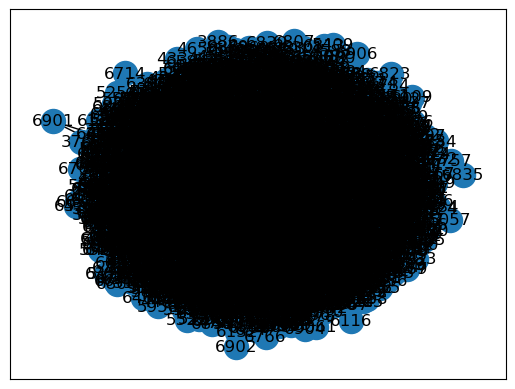

In [12]:
# Create an empty graph
G = nx.Graph()

# Iterate over the DataFrame rows and add nodes to the graph
for index, row in reader.iterrows():
    from_node = row["%"]
    to_node = row["bip"]
    weight = row["positive"]
        
    # Add the nodes to the graph
    G.add_node(from_node)
    G.add_node(to_node)
    
    # Add an edge between the nodes
    G.add_edge(from_node, to_node, weight=weight)

# Draw the graph
nx.draw_networkx(G, with_labels=True)
plt.show()

In [13]:
def print_graph_stats(title, G):
    print("Simple stats for: " + title)
    print("Number of nodes: " + str(len(G.nodes())))
    print("Number of edges: " + str(len(G.edges())))
    print("Graph density: " + str(nx.density(G)))
    print("Is graph connected? " + str(nx.is_connected(G)))
    print("Graph type: " + str(type(G)))
    
print_graph_stats("Daily-Kos", G)

Simple stats for: Daily-Kos
Number of nodes: 6906
Number of edges: 349842
Graph density: 0.014672755674472533
Is graph connected? True
Graph type: <class 'networkx.classes.graph.Graph'>


In the provided content, the graph has a density of 0.014672755674472533, indicating sparsity, but it is connected, meaning there is a path between every pair of nodes in the graph.

In [14]:
print("Number of Connected Components in Graph: {}".format(nx.number_connected_components(G)))

Number of Connected Components in Graph: 1


In [15]:
list(G.nodes(data = True))[0:5:None]

[(1, {}), (2, {}), (3, {}), (4, {}), (5, {})]

In [16]:
list(G.edges(data = True))[0:5]

[(1, 1, {'weight': 2}),
 (1, 2, {'weight': 1}),
 (1, 3, {'weight': 1}),
 (1, 4, {'weight': 1}),
 (1, 5, {'weight': 1})]

In [17]:
# Check if the graph is bipartite
is_bipartite = nx.is_bipartite(G)

if is_bipartite:
    print("The graph is bipartite.")
else:
    print("The graph is not bipartite.")

The graph is not bipartite.


Based on the findings, it can be concluded that the graph does not satisfy the criteria of being a true bipartite graph. Consequently, we will merge the *Konect data* and *UCI dataset* together to conduct a comprehensive network analysis.

### Combine KONECT and UCI dataset: 

In [18]:
# Read node list from text file
with open('vocab.kos.txt', 'r') as file:
    nodes = file.read().splitlines()

# Create DataFrame from the node list
df_nodes = pd.DataFrame(nodes, columns=['Node'])

# Concatenate the DataFrames
df_merged = pd.concat([df_nodes, reader], axis=1)

# Create an empty graph
C = nx.Graph()

# Add nodes to the graph
C.add_nodes_from(df_merged['Node'])

# Iterate over the DataFrame rows and add edges to the graph
for index, row in df_merged.iterrows():
    from_node = row['Node']
    to_node = row['bip']
    weight = row['positive']

    # Add an edge between the nodes
    C.add_edge(from_node, to_node, weight=weight)

# Draw the graph
#nx.draw_networkx(G, with_labels=True)
#plt.show()

In [19]:
# View the merged datasets
df_merged.head()

,Node,%,bip,positive
0,aarp,1,1,2
1,abandon,1,2,1
2,abandoned,1,3,1
3,abandoning,1,4,1
4,abb,1,5,1


In [20]:
print("Is the graph bipartite: ", bipartite.is_bipartite(C))

Is the graph bipartite:  True


In [21]:
# View the nodes
list(C.nodes(data = True))[0:5:None]

[('aarp', {}),
 ('abandon', {}),
 ('abandoned', {}),
 ('abandoning', {}),
 ('abb', {})]

In [22]:
# View the edge-list
list(C.edges(data = True))[0:5]

[('aarp', 1, {'weight': 2}),
 ('abandon', 2, {'weight': 1}),
 ('abandoned', 3, {'weight': 1}),
 ('abandoning', 4, {'weight': 1}),
 ('abb', 5, {'weight': 1})]

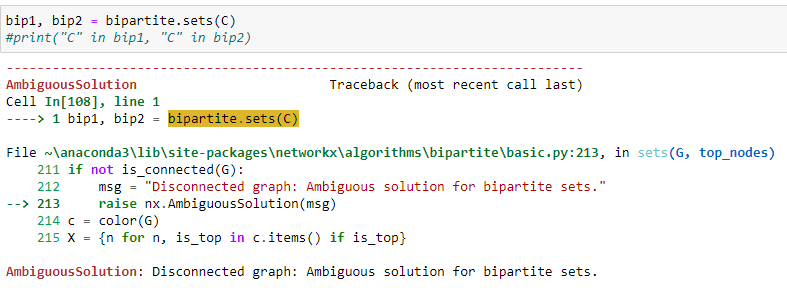

In this below code snippet, the *bipartite.sets()* function takes a bipartite graph as input and returns two sets: bip1 and bip2. These sets represent the two disjoint sets of nodes in the bipartite graph.

**This code did not work correctly, `C` is not a valid bipartite graph in NetworkX.**

*Explanation:* A disconnected graph is a graph consisting of separate components that are not connected by any edges. In the context of bipartite sets, a disconnected graph leads to an ambiguous solution because there are no constraints or information guiding the assignment of nodes to the bipartite sets. Each disconnected component can potentially form its own bipartite set, but there is no definitive way to determine which nodes belong to the top set and which nodes belong to the bottom set without additional criteria or constraints.

**Explore Neighborhood**

We can still explore the neighborhood of disconnected graphs allowing for the analysis of individual connected components, examination of local relationships, understanding network connectivity within each component, and visualizing the graph's structure.

In [23]:
#exploring neighborhood of the node ["aarp"]
alters2 = C["aarp"]
print("Length: ", (len(alters2)), "\nNeighborhood: ", alters2)

Length:  1 
Neighborhood:  {1: {'weight': 2}}


In [24]:
#exploring all neighborhoods of the node ["aarp"]
alters21 = list(nx.all_neighbors(C, "aarp"))
print("All neighborhoods: ", alters21)

All neighborhoods:  [1]


In [25]:
#exploring neighborhood of the edgelist [1]
alters1 = C[1]
print("Length: ", (len(alters1)), "\nNeighborhood: ", alters1)

Length:  3 
Neighborhood:  {'aarp': {'weight': 2}, 'sentences': {'weight': 1}, nan: {'weight': 1}}


In [26]:
#exploring all neighborhoods of the edgelist [1]
alters12 = list(nx.all_neighbors(C, 1))
print("All neighborhoods: ", alters12)

All neighborhoods:  ['aarp', 'sentences', nan]


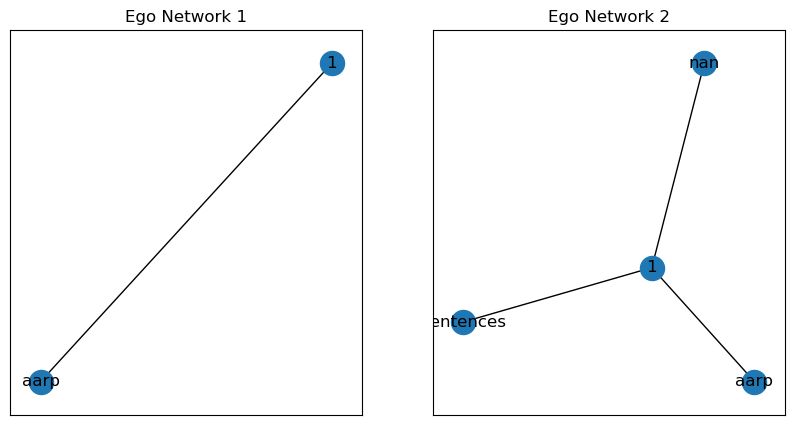

In [27]:
# Create the ego networks
egonet_3 = nx.ego_graph(C, 1)
egonet_2 = nx.ego_graph(C, "aarp")

# Create the figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first graph on the left subplot
plt.sca(axes[0])
nx.draw_networkx(egonet_2)
plt.title("Ego Network 1")

# Plot the second graph on the right subplot
plt.sca(axes[1])
nx.draw_networkx(egonet_3)
plt.title("Ego Network 2")

# Display the plots
plt.show()

These two different `Ego Network` provide visual description regarding neighborhoods, edges, and node connections. The first network focuses on the specific neighborhood around the 'aarp' node, while the second statement refers to a broader context involving an '1' edgelist and its neighborhood in the graph.

### Explore Neighborhoods with KONECT dataset

**Network Neighborhood of a Node** 

Textbook: Complex Network Analysis in Python

In [28]:
# Specify the range of nodes
start_node = 1
end_node = 6906

# Find the subgraph within the specified range of nodes
subgraph = G.subgraph(range(start_node, end_node + 1))

# Find the node with the maximum node size in the subgraph
max_node = max(subgraph.degree(), key=lambda x: x[1])[0]

# Find the node with the minimum node size in the subgraph
min_node = min(subgraph.degree(), key=lambda x: x[1])[0]

print("Node with the maximum node size within the specified range:", max_node)
print("Node with the minimum node size within the specified range:", min_node)

Node with the maximum node size within the specified range: 14
Node with the minimum node size within the specified range: 5853


In [29]:
# Specify the threshold for node size
threshold = 4

# Find the nodes with node sizes less than or greater than the specified threshold
nodes_less_than_threshold = [node for node, degree in G.degree() if degree < threshold]
nodes_greater_than_threshold = [node for node, degree in G.degree() if degree > threshold]

print("Nodes with node sizes less than the threshold:")
count = 0
for node in nodes_less_than_threshold:
    if count < 5:
        print(node)
        count += 1
    else:
        break

print("\nNodes with node sizes greater than the threshold:")
count = 0
for node in nodes_greater_than_threshold:
    if count < 5:
        print(node)
        count += 1
    else:
        break

Nodes with node sizes less than the threshold:
4107
4174
4314
4315
4326

Nodes with node sizes greater than the threshold:
1
2
3
4
5


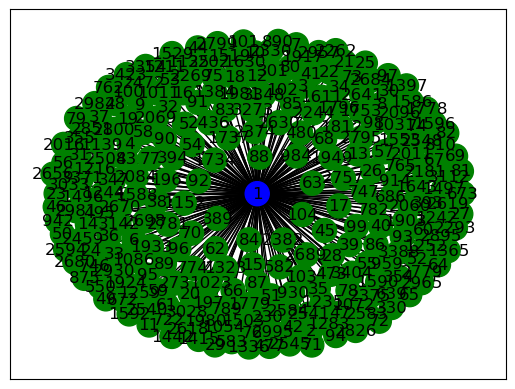

In [30]:
# Create the egonet graph
egonet = nx.ego_graph(G, 1)
G4 = nx.star_graph(egonet)

# Set node colors
node_colors = {node: 'blue' if node == 1 else 'green' for node in G4.nodes()}

# Draw the egonet graph with specified colors
nx.draw_networkx(G4, node_color=list(node_colors.values()))

# Display the graph
plt.show()

In [31]:
# Calculate clustering coefficients and transitivity of the graph
cc = nx.clustering(nx.Graph(G), 1)
mean_cc = nx.average_clustering(nx.Graph(G))
trans = nx.transitivity(G)

# Create a dataframe with the results
cc_trans = pd.DataFrame({
    'Node': ['1'],
    'Clustering Coefficient': [cc],
    'Mean Clustering Coefficient': [mean_cc],
    'Transitivity': [trans]
})

# Print the dataframe
print(cc_trans)

  Node  Clustering Coefficient  Mean Clustering Coefficient  Transitivity
0    1                0.102383                     0.080945      0.089142


The results indicates:
- Node 1 has a clustering coefficient of 0.102383, indicating some clustering or interconnectedness among its neighbors.
- The mean clustering coefficient for the graph is 0.080945, representing the overall tendency of nodes to form clusters.
- The transitivity of the graph is 0.089142, indicating a moderate likelihood of interconnectedness between nodes.

In [32]:
#Comparing the Centralities
dgr = nx.degree_centrality(G)
eig = nx.eigenvector_centrality(G)
pgr = nx.pagerank(G)
hits = nx.hits(G)
centralities = pd.concat(
[pd.Series(c) for c in (hits[1], eig, pgr, hits[0], dgr)], axis=1)
centralities.columns = ("Authorities", "Eigenvector", "PageRank", "Hubs", "Degree")
#centralities.head(5)

In [56]:
table = pd.DataFrame(centralities)
table.sort_values(by=['Degree', 'Hubs'], ascending = False).head(5)

,Authorities,Eigenvector,PageRank,Hubs,Degree
14,0.005857,0.122059,0.006027,0.005857,0.309196
41,0.001861,0.101061,0.002058,0.001861,0.245909
56,0.003966,0.096296,0.004125,0.003966,0.237219
181,0.002203,0.095158,0.002357,0.002203,0.223461
222,0.002386,0.083496,0.002448,0.002386,0.195221


Interpretation on the centrality measures for the highest ranked node: Node 14 has relatively low scores for authorities, PageRank, and hubs centrality measures. However, it has a moderate eigenvector centrality score, suggesting connections to influential nodes. Additionally, Node 14 has a degree centrality of 0.309196, indicating a moderate number of connections to other nodes in the graph.

In [33]:
# Calculate the correlations for each pair of centralities
c_df = centralities.corr()
ll_triangle = np.tri(c_df.shape[0], k=-1)
c_df *= ll_triangle
c_series = c_df.stack().sort_values()
c_series.tail()

Hubs      PageRank       0.933423
PageRank  Authorities    0.933423
Degree    PageRank       0.942915
          Eigenvector    0.955115
Hubs      Authorities    1.000000
dtype: float64

In summary, the results highlight the correlations or similarities between different centrality measures in the graph. These measures include "Hubs," "PageRank," "Authorities," "Degree," and "Eigenvector." The values in the table represent the degree of similarity or correlation between pairs of centrality measures, with higher values indicating stronger relationships.

<Axes: xlabel='Authorities', ylabel='Eigenvector'>

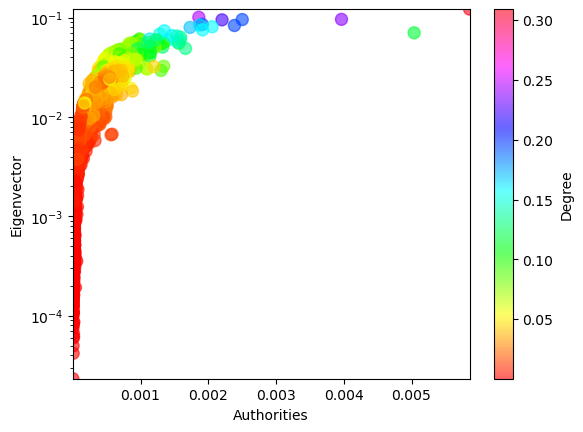

In [34]:
#import pandas as pd

X = "Authorities"
Y = "Eigenvector"

# Calculate the limits for X and Y
limits = pd.concat([centralities[[X, Y]].min(), centralities[[X, Y]].max()], axis=1).values

# Define the color variable
color_variable = "Degree"  # Replace with the desired variable from your centralities DataFrame

# Scatter plot with color
#colormap: viridis, plasma, inferno, magma, cividis
centralities.plot(kind="scatter", x=X, y=Y, c=color_variable, colormap="hsv",
                  xlim=limits[0], ylim=limits[1], s=75, logy=True, alpha=0.6)

A scatter plot with color mapping based on a variable from the centralities DataFrame. The x-axis variable is "Authorities", the y-axis variable is "Eigenvector", and the color mapping is determined by the "Degree" variable. 

**Network Analysis Summary**, Node 14 stands out with the maximum node size in the given range. While it demonstrates relatively low scores for authorities, PageRank, and hubs centrality measures, it possesses a moderate eigenvector centrality score, indicating connections to influential nodes. Additionally, its degree centrality suggests a moderate level of connectivity to other nodes.

#### Visualize Node Subgraph Plot with Neighbor Criteria

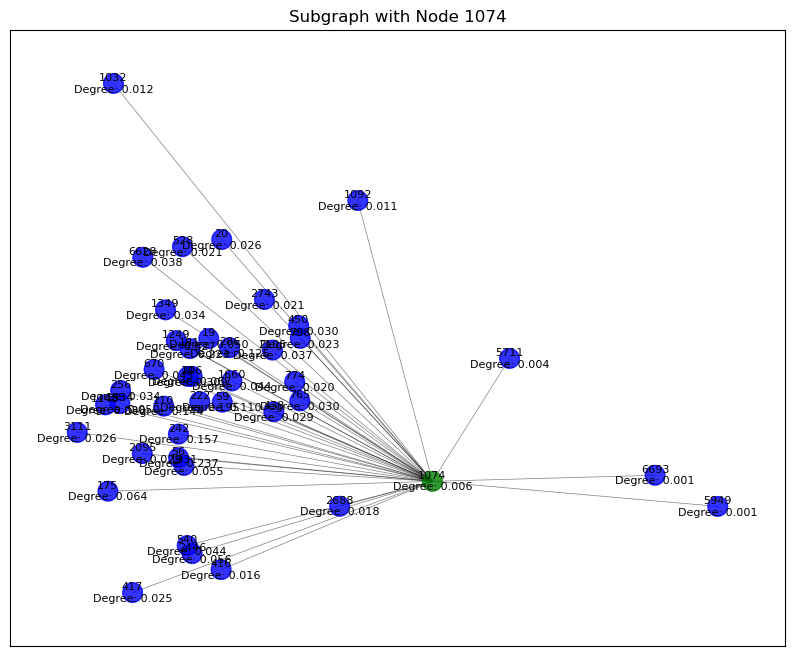

In [35]:
# Specify the node to plot
node_to_plot = 1074

# Create a subgraph with the specified node
subgraph = nx.Graph()
subgraph.add_node(node_to_plot)

for neighbor in G.neighbors(node_to_plot):
    subgraph.add_edge(node_to_plot, neighbor)

# Plot the subgraph
plt.figure(figsize=(10, 8))

# Extract node positions from the original graph 'G'
pos = nx.spring_layout(G)

# Draw the nodes of the subgraph
node_colors = ['green' if node == 1074 else 'blue' for node in subgraph.nodes()]
nx.draw_networkx_nodes(subgraph, pos, node_size=200, node_color=node_colors, alpha=0.8)

# Draw the edges of the subgraph
nx.draw_networkx_edges(subgraph, pos, width=0.5, alpha=0.5)

# Customize node labels
labels = {node: f"{node}\nDegree: {centralities['Degree'][node]:.3f}" for node in subgraph.nodes()}
nx.draw_networkx_labels(subgraph, pos, labels, font_size=8, font_color='black')

# Set plot title
plt.title(f"Subgraph with Node {node_to_plot}")

# Display the plot
plt.show()

## Natural Language Processing 

We will apply Natural Language Processing (NLP) to the bag-of-words model. The UCI dataset is a simple representation of text data that focuses on the occurrence and frequency of individual words within a document. It disregards grammar, word order, and context, treating each document as an unordered collection or "bag" of words.

### Required libraries/packages

In [37]:
#natural language toolkit
import nltk

#read and process plaintext documents
from nltk.corpus import PlaintextCorpusReader

#frequency distribution of a collection of items
from nltk.probability import FreqDist

#for looping and iteration
import itertools
from itertools import chain

#visual representation of text data
from wordcloud import WordCloud

### Document extraction and Word frequency 

In [38]:
def parse_bag_of_words_file(docword, vocab):
    with open(vocab, "r") as f:
        kos_vocab = [word.strip() for word in f.readlines()]
        id_to_word = {i: word for i, word in enumerate(kos_vocab)}

    with open(docword, "r") as f:
        raw = [list(map(int, _.strip().split())) for _ in f.readlines()][3:]

    docs = []
    for _, grp in itertools.groupby(raw, lambda x: x[0]):
        doc = []
        for _, word_id, word_cnt in grp:
            doc += word_cnt * [id_to_word[word_id-1]]
        docs.append(doc)
    return docs, id_to_word

In [39]:
docs, id_to_word = parse_bag_of_words_file("docword.kos.txt", "vocab.kos.txt")
vocab_size = len(set(word for doc in docs for word in doc))

In [40]:
# Print the first document
print(docs[0])

['action', 'action', 'added', 'administration', 'alliances', 'antiwar', 'approve', 'assault', 'attack', 'attitude', 'attitude', 'aug', 'battle', 'believes', 'broad', 'bush', 'bush', 'career', 'chairman', 'click', 'coalition', 'committee', 'committee', 'compared', 'compared', 'conclude', 'conclusion', 'conclusions', 'congressional', 'congressional', 'congressman', 'congressman', 'considered', 'constituents', 'constituents', 'countrys', 'damaging', 'damn', 'departure', 'destruction', 'district', 'district', 'doug', 'doug', 'dramatic', 'electorate', 'engaged', 'enlarge', 'fact', 'final', 'general', 'general', 'gooper', 'greater', 'hold', 'house', 'house', 'households', 'households', 'inadequate', 'incidentally', 'independents', 'intelligence', 'intelligence', 'intelligence', 'international', 'international', 'iraq', 'iraq', 'ive', 'john', 'justified', 'kerry', 'kerry', 'kerry', 'knowing', 'launch', 'lead', 'letter', 'lower', 'maintained', 'mass', 'member', 'military', 'military', 'militar

*Interpretation:* We parsed the bag-of-words file and extracted the documents and their corresponding word frequencies. We next calculated the vocab_size by counting the number of unique words in all the documents. It uses a nested generator expression that iterates over docs and words in each doc and passes these words to a set to remove duplicates. The resulting set is then passed to len() to get the count.

We print the first document in the docs list (docs[0]), representing a list of words for the first document in the bag-of-words file for observation.

#### Word Cloud Visualization

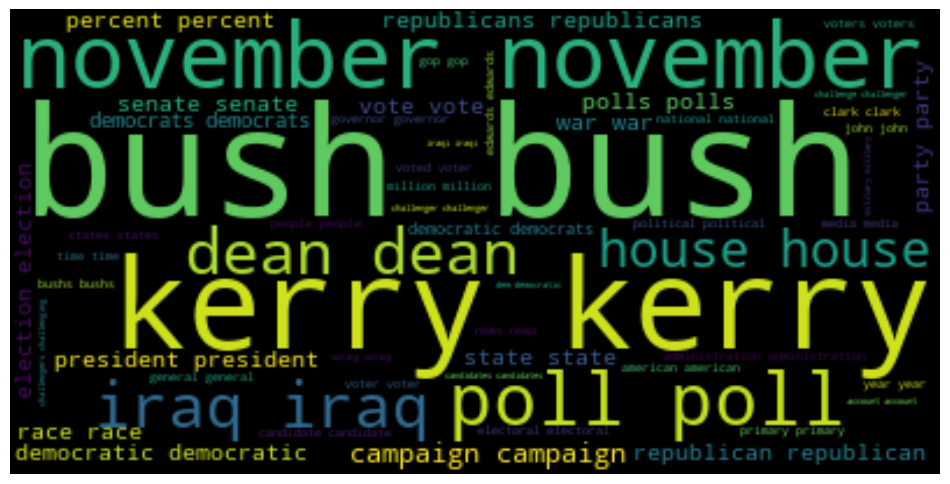

In [41]:
# Bag-of-words representation
bag_of_words = docs

# Flatten the list of lists into a single list
flattened_words = list(chain.from_iterable(bag_of_words))

# Join the words into a single string
text = " ".join(flattened_words)

# Generate the word cloud
wordcloud = WordCloud().generate(text)

# Create the plot and display the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

A word cloud visualization is generated based on the bag-of-words representation of documents. The resulting word cloud provides a visual summary of the most frequent words in the text data.

#### Frequency Distribution with a Scatterplot Display

In [43]:
# Look up a word by its ID
word_id = 20
word = id_to_word[word_id]
print(word)

abstain


In [42]:
# Bag-of-words representation
bag_of_words = docs

# Flatten the list of lists into a single list
#flattened_words = list(chain.from_iterable(bag_of_words))

# Calculate the frequency distribution
freq_dist = FreqDist(flattened_words)

# Print the top 10 unique words and their counts
for word, count in freq_dist.most_common(10):
    print(word, count)

bush 6781
kerry 4679
november 3781
poll 2640
democratic 2566
house 2450
war 2364
general 2252
iraq 2217
campaign 1992


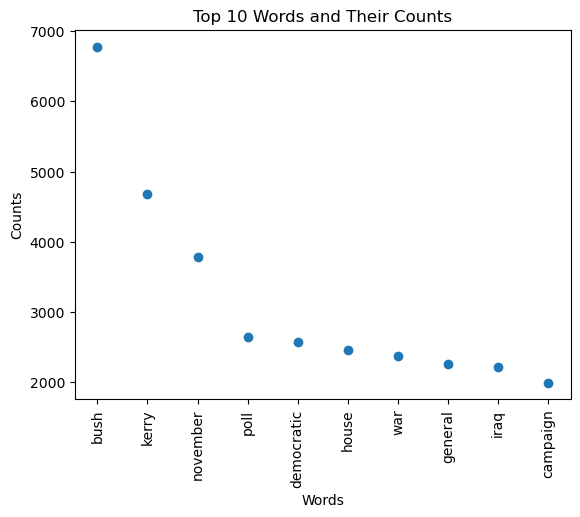

In [44]:
# Bag-of-words representation
bag_of_words = docs

# Flatten the list of lists into a single list
#flattened_words = list(chain.from_iterable(bag_of_words))

# Calculate the frequency distribution
#freq_dist = FreqDist(flattened_words)

# Get the top 10 unique words and their counts
top_words = freq_dist.most_common(10)

# Extract the words and counts into separate lists
words, counts = zip(*top_words)

# Create a scatter plot
plt.scatter(words, counts)

# Set labels and title
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Top 10 Words and Their Counts')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=90)

# Display the plot
plt.show()


*Interpretation:* We calculated the frequency distribution of words in the bag-of-words representation, selected the top 10 most frequent words and their counts, and provided a visual count using a scatter plot. The resulting plot provides an overview of the frequency distribution of the top words in the text data.

### Part-of-Speech Tagging

Part-of-speech tagging is crucial in natural language processing. It assigns a grammatical category to every word in a text, such as a noun, verb, or adjective. This information is necessary for downstream applications, providing insight into the role of words in a sentence. Ultimately, part-of-speech tagging is a critical tool for NLP tasks, allowing us to understand better and analyze language.

In [45]:
# Perform part-of-speech tagging
pos_tags = nltk.pos_tag(flattened_words)

# Create a DataFrame from the pos_tags list
df = pd.DataFrame(pos_tags, columns=['Word', 'POS Tag'])

# Print the DataFrame
print(df.head(10))

             Word POS Tag
0          action      NN
1          action      NN
2           added     VBD
3  administration      NN
4       alliances     NNS
5         antiwar     VBP
6         approve      VB
7         assault      NN
8          attack      JJ
9        attitude      JJ


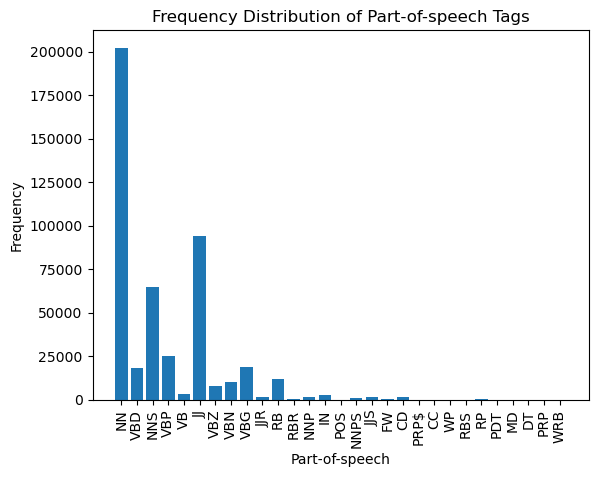

In [46]:
# Perform part-of-speech tagging
pos_tags = nltk.pos_tag(flattened_words)

# Create a frequency distribution of the part-of-speech tags
pos_freq_dist = FreqDist(tag for (word, tag) in pos_tags)

# Set a minimum count threshold for displaying tags on the plot
min_count = 5
filtered_pos_freq_dist = {tag: count for tag, count in pos_freq_dist.items() if count >= min_count}

# Plot the frequency distribution
plt.bar(filtered_pos_freq_dist.keys(), filtered_pos_freq_dist.values())

# Set labels and title
plt.xlabel('Part-of-speech')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Part-of-speech Tags')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=90)

# Display the plot
plt.show()

The top five of the POS tags explanation:

1. nn - Singular noun
2. vbd - Past tense verb
3. nns - Plural noun
4. jj - Adjective
5. vbg - Verb in the -ing form (present participle or gerund)

These tags are used to categorize words based on their roles in a sentence, such as identifying nouns, verbs in different tenses, adjectives, and verbs in the -ing form.

*Interpretation:*  We analyzed some text data and found that part-of-speech tagging on a list of words `(flattened_words)` allowed us to categorize each word according to its grammatical function. We created a DataFrame to store the results and printed the first ten rows to understand the data structure and format. One interesting finding was the frequency distribution of the different part-of-speech categories. To visualize this, we generated a bar plot showing the relative frequencies of each category. The plot gave us an understanding of the linguistic patterns and was a valuable tool for understanding the underlying structure and patterns in our text data.

### Hierarchical Dirichlet Process (HDP)

We experimented with Hierarchical Dirichlet Process (HDP) , a probabilistic model used in NLP to improve bag-of-words representations. With HDP, NLP can discover topics, handle variable-length sequences, and capture word relationships, allowing for more meaningful representations of textual data.

##### Required Libraries/Packages

In [52]:
# topic modelling, document indexing, and similarity retrieval 
from gensim.models import HdpModel
from gensim.corpora import Dictionary

##### PreProcess, Model, and Discover Topics

In [53]:
# Preprocess the data
docs, id_to_word = parse_bag_of_words_file("docword.kos.txt", "vocab.kos.txt")
dictionary = Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]

# Define and train the HDP model
hdp_model = HdpModel(corpus, id2word=dictionary)

# Print inferred topics
topics = hdp_model.show_topics(num_topics=5, num_words=10)
for topic_id, topic in topics:
    print(f"Topic ID: {topic_id}")
    print(f"Top words: {topic}\n")


Topic ID: 0
Top words: 0.014*bush + 0.010*kerry + 0.008*november + 0.006*poll + 0.006*democratic + 0.005*house + 0.005*general + 0.005*war + 0.004*senate + 0.004*iraq

Topic ID: 1
Top words: 0.011*bush + 0.008*kerry + 0.005*democratic + 0.004*dean + 0.004*party + 0.004*house + 0.004*campaign + 0.004*poll + 0.004*people + 0.004*time

Topic ID: 2
Top words: 0.013*bush + 0.009*kerry + 0.005*dean + 0.005*iraq + 0.005*war + 0.005*campaign + 0.004*president + 0.004*democratic + 0.003*house + 0.003*general

Topic ID: 3
Top words: 0.014*november + 0.011*bush + 0.006*kerry + 0.005*house + 0.005*war + 0.004*iraq + 0.004*poll + 0.004*republicans + 0.004*general + 0.004*senate

Topic ID: 4
Top words: 0.014*november + 0.009*bush + 0.007*kerry + 0.004*house + 0.004*poll + 0.004*republicans + 0.004*senate + 0.003*general + 0.003*war + 0.003*governor



*Interpretation:* The top words associated with different topics identified by the HDP model algorithm show that each topic is assigned an ID, and the top words are ranked based on their importance within that topic.

For example:
- Topic ID 0: This topic seems to be related to the 2004 U.S. presidential election, with words like "bush," "kerry," "november," "iraq," and "war" appearing as the most significant. It may pertain to discussions about the Democratic Party, polling, and the general election.

- Topic ID 1: This topic also revolves around the 2004 U.S. presidential election, with a focus on candidates like "kerry" and "bush." It may highlight discussions about the Democratic Party, polling, and the campaign.

- Topic ID 2: This topic shares similarities with the previous ones, mentioning "bush," "kerry," "war," and "iraq." It may be related to discussions about the Democratic Party, campaigning, and the general public's sentiment.

- Topic ID 3: This topic is likely about the November elections and focuses on various political aspects such as polling, Senate, House, and Republican Party.

- Topic ID 4: This topic seems to touch on the Iraq war, Bush's administration, and news coverage.

#### Visualize the HDP model with pyLDAvis

We discovered that pyLDAvis can visualize both LDA and gensim HDP models. The main difference between HDP and LDA is that HDP is a non-parametric method, meaning that the number of topics does not need to be specified beforehand. HDP fits as many topics as possible and finds the optimal number.

##### Required Libraries/Packages

In [47]:
# interactive topic model visualization
import pyLDAvis
import pyLDAvis.gensim_models

In [48]:
import pyLDAvis.gensim_models as gensimvis

In [54]:
#from IPython.core.display import display, HTML
from IPython.display import display, HTML
display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

##### Interactive Model (HDP) with pyLDAvis

In [55]:
vis_data = gensimvis.prepare(hdp_model, corpus, dictionary, sort_topics = False)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis_data)

This interactive visualization is a great tool for gaining insights into the topics and their relationships in the HDP model. The plot shows the distribution of topics, the most relevant terms for each topic, and other interactive elements like word clouds or topic interactivity graphs. It is an excellent way to explore and understand the underlying topics in the corpus and their connections. One of the features that stand out is the **"Slide to adjust relevance metric,"** which enables you to fine-tune the level of detail and specificity you want to see in the visualization based on your preferences or the specific requirements of your analysis.

### Latent Dirichlet Allocation (LDA)

After completing our initial training, we decided to move forward with an LDA model. This was because we found that the HDP model needed a more complex way to evaluate the quality and effectiveness of the generated topics, likely due to its complex hierarchical structure and infinite number of topics. 

##### Required Libraries/Packages

In [56]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

##### Model LDA

In [57]:
# Train the LDA model
lda_model = LdaModel(corpus, id2word=dictionary, num_topics=20)  # Adjust the number of topics as needed

#### Interactive LDA model with pyLDAvis

In [58]:
#https://github.com/bmabey/pyLDAvis/blob/master/notebooks/Gensim%20Newsgroup.ipynb
vis_data2 = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis_data2)

We ran an interactive visualization of the LDA model using pyLDAvis based on the data prepared in the previous step. It showed the discovered topics and their interrelationships, which gave us valuable insights into the corpus's topic structure. We specified the model parameter to be `20,` which allowed the LDA model to discover 20 topics in the corpus. 

#### LDA Model Measures

To evaluate the quality of the LDA model, we used **coherence score** and **perplexity** as evaluation metrics. These metrics provided insights into how well the model performs and its effectiveness in capturing meaningful and coherent topics within the corpus.

In [59]:
# Compute the coherence score
coherence_model = CoherenceModel(
    model=lda_model,
    texts=docs,
    dictionary=dictionary,
    coherence='c_v'  # Choose coherence measure, such as 'c_v', 'u_mass', 'c_uci', 'c_npmi'
)
coherence_score = coherence_model.get_coherence()

print("Coherence Score:", coherence_score)

Coherence Score: 0.26369420430573626


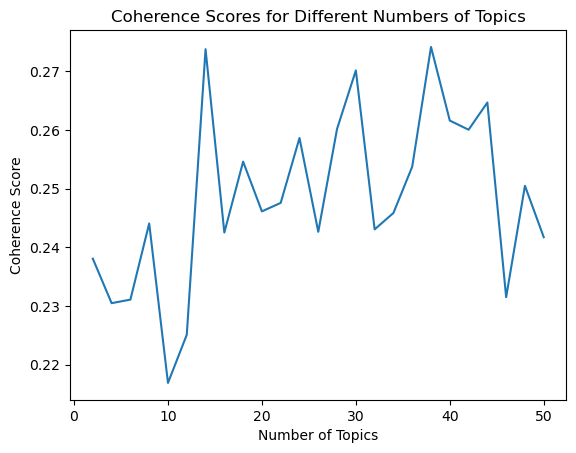

In [60]:
# Define a range of topic numbers to evaluate
start_topic_num = 2
end_topic_num = 50
step = 2
topic_nums = range(start_topic_num, end_topic_num + 1, step)

# Compute coherence scores for different numbers of topics
coherence_scores = []
for num_topics in topic_nums:
    lda_model = LdaModel(corpus, id2word=dictionary, num_topics=num_topics)
    coherence_model = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

# Plot the coherence scores
plt.plot(topic_nums, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores for Different Numbers of Topics")
plt.show()


In [29]:
# Compute perplexity
perplexity = lda_model.log_perplexity(corpus)

print("Perplexity:", perplexity)

Perplexity: -8.724201429761752


*Interpretation:* The coherence score of 0.2637 suggests moderate topic coherence, meaning the generated topics have some semantic similarity. The perplexity score of -8.724 indicates reasonably good performance in predicting unseen data, with lower scores being better. Comparing these scores to other models or benchmarks on the same dataset would provide more context and help evaluate the model's performance more accurately.

#### Tagging using the LDA model

We used a tagger for documents based on topic distribution using the LDA model. It groups documents by tags and plots the distribution by topic, which helps organize and analyze large sets of documents.

##### Required Libraries/Packages

In [69]:
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

##### Tag Documents

In [62]:
# Tag the documents based on their topic distribution
document_tags = []
for document in corpus:
    doc_topics = lda_model.get_document_topics(document)
    tags = [topic for topic, _ in doc_topics]
    document_tags.append(tags)

In [63]:
# Group the documents based on their tags
tagged_documents = defaultdict(list)
for doc_id, tags in enumerate(document_tags):
    for tag in tags:
        tagged_documents[tag].append(doc_id)

##### Distribution Plot 

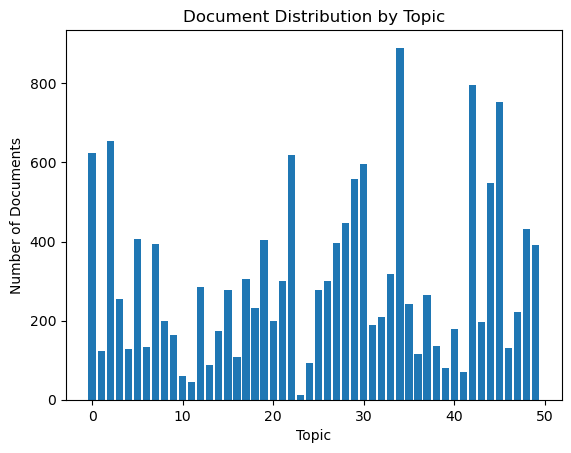

In [64]:
# Plot the document groups
x = list(tagged_documents.keys())
y = [len(docs) for docs in tagged_documents.values()]

plt.bar(x, y)
plt.xlabel('Topic')
plt.ylabel('Number of Documents')
plt.title('Document Distribution by Topic')
plt.show()


##### Test Topic Distribution on a Random Document

In [65]:
# Get the topic distribution for a document
document = "Some third-party carriers are seeing a boost in their \
businesses as the possibility of a UPS strike comes into focus for \
their clients. Stord, a third-party logistics and technology provider \
based in Atlanta whose clients include apparel makers and consumer-package \
companies, has been sending emails out telling its clients not to worry. \
Stord uses a cloud-based platform to offer services like warehousing and \
fulfillment and handles tens of thousands of their packages a day."  # Provide your document here

In [70]:
# Tokenize the document into words
document_words = word_tokenize(document)

# Perform POS tagging on the document
tagged_words = pos_tag(document_words)

# Create an empty list to store the POS-tagged words
pos_list = []

# Iterate over the tagged_words for the first five words
for i, (word, pos) in enumerate(tagged_words):
    # Append each word and POS tag as a dictionary to the list
    pos_list.append({'Word': word, 'POS': pos})
    
    # Break the loop after five words
    if i == 4:
        break

# Create a DataFrame from the list of POS-tagged words
df_pos = pd.DataFrame(pos_list)

# Print the DataFrame
print(df_pos)

          Word  POS
0         Some   DT
1  third-party   JJ
2     carriers  NNS
3          are  VBP
4       seeing  VBG


In [74]:
# Create an empty list to store the topics and scores
topic_list = []

# Get the topic distribution for the document using LDA
document_bow = dictionary.doc2bow(document_words)
document_topics = lda_model.get_document_topics(document_bow)

# Iterate over the document_topics
for topic, score in document_topics:
    # Append each topic and score as a dictionary to the list
    topic_list.append({'Topic': topic, 'Score': score})

# Create a DataFrame from the list of topics
df_topics = pd.DataFrame(topic_list)

# Print the DataFrame
print(df_topics)

   Topic     Score
0      2  0.284640
1     17  0.068265
2     19  0.273775
3     35  0.331451


In this section, we have reviewed the steps in breaking down a document into individual words, labeling each word with its corresponding part of speech, and organizing the results into a DataFrame. Additionally, we have explored how to determine the distribution of topics within the document using Latent Dirichlet Allocation (LDA) and created a separate DataFrame to store the resulting topics and their corresponding scores.

## Machine Learning Algorithm

Finally, using machine learning algorithms on the bag-of-words (BoW) for text classification will effectively improve accuracy. BoW helps represent text as word frequency vectors, making it easier for machine learning algorithms to learn and accurately predict the category of new text documents. By extracting features from the BoW representation and optimizing their models, these algorithms can use ensemble methods to enhance accuracy further. Using machine learning algorithms on BoW is an innovative and efficient way to improve text classification accuracy.

### Required Libraries/Packages

In [86]:
#required libraries
from gensim.corpora import Dictionary

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tabulate import tabulate
from sklearn.metrics import accuracy_score
from gensim.matutils import corpus2dense

In [78]:
# Prepare the data for training
sequences = [dictionary.doc2bow(doc) for doc in docs]
X = corpus2dense(sequences, num_terms=len(id_to_word)).T
y = np.array([0, 1] * (len(docs) // 2))  # Example binary labels, adjust accordingly

In [79]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
# Define the models
logreg_model = LogisticRegression()
rf_model = RandomForestClassifier()
xgb_model = xgb.XGBClassifier()

In [81]:
# Train the models
logreg_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [82]:
# Make predictions on the test set
logreg_pred = logreg_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)



In [83]:
# Evaluate the models
accuracy_logreg = accuracy_score(y_test, logreg_pred)
accuracy_rf = accuracy_score(y_test, rf_pred)
accuracy_xgb = accuracy_score(y_test, xgb_pred)

# Generate classification reports
report_logreg = classification_report(y_test, logreg_pred)
report_rf = classification_report(y_test, rf_pred)
report_xgb = classification_report(y_test, xgb_pred)

In [84]:
# Create a table of results
data = {'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
        'Accuracy': [accuracy_logreg, accuracy_rf, accuracy_xgb],
        'Classification Report': [report_logreg, report_rf, report_xgb]}
#df = pd.DataFrame(data)

In [85]:
# Display the table
print(tabulate(data, headers='keys', tablefmt='psql'))

+---------------------+------------+-------------------------------------------------------+
| Model               |   Accuracy | Classification Report                                 |
|---------------------+------------+-------------------------------------------------------|
| Logistic Regression |   0.46793  | precision    recall  f1-score   support               |
|                     |            |                                                       |
|                     |            |            0       0.46      0.48      0.47       339 |
|                     |            |            1       0.47      0.46      0.47       347 |
|                     |            |                                                       |
|                     |            |     accuracy                           0.47       686 |
|                     |            |    macro avg       0.47      0.47      0.47       686 |
|                     |            | weighted avg       0.47      0.47

*Interpretation:* Logistic regression had an accuracy of approximately 46.7%, random forest had an accuracy of around 44.5%, and XGBoost had an accuracy of about 47.2%. These scores represent how well the models performed in correctly classifying the data.

### ROC curve with AUC (Area Under the Curve)

#### Required Libraries/Packages

In [ ]:
from sklearn.metrics import roc_curve, auc

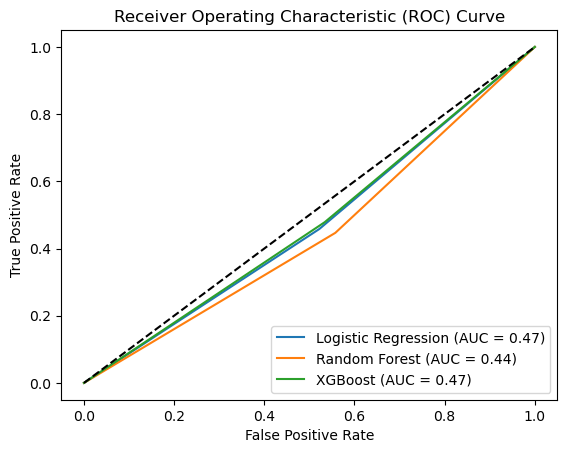

In [89]:
# Compute the false positive rate (fpr), true positive rate (tpr), and thresholds for Logistic Regression
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, logreg_pred)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

# Compute the false positive rate (fpr), true positive rate (tpr), and thresholds for Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf_pred)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Compute the false positive rate (fpr), true positive rate (tpr), and thresholds for XGBoost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb_pred)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_logreg, tpr_logreg, label='Logistic Regression (AUC = %0.2f)' % roc_auc_logreg)
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


The plot above shows the ROC curve for each model, with the AUC (Area Under the Curve) value displayed in the legend. The diagonal line represents random guessing, and the closer the curve is to the top-left corner, the better the model's performance.

## Summary

**The project analyzed connections between documents and words in the Daily Kos dataset. Two repositories were used: one on Konect and another on the UCI Machine Learning Repository. We combined these datasets and could not perform a thorough network analysis because the bipartite graphs were disconnected. Using the Konect dataset, they found that Node 14 had the highest node size within the given range. We also used the Hierarchical Dirichlet Process (HDP) model algorithm to identify topics within the dataset and evaluated the performance of different machine learning models. Logistic regression, random forest, and XGBoost had varying accuracy scores in classifying the data.**

## References

Bird, S., Klein, E., & Loper, E. (2009). Natural Language Processing with Python: Analyzing Text with the Natural Language Toolkit. “O’Reilly Media, Inc.”

Zinoviev, D. (2018). Complex Network Analysis in Python: Recognize - Construct - Visualize - Analyze - Interpret.

[Daily Kos. (n.d.).]( http://konect.cc/networks/bag-kos/)

[Bmabey. (n.d.). pyLDAvis/notebooks/Gensim Newsgroup.ipynb at master · bmabey/pyLDAvis. GitHub. ](https://github.com/bmabey/pyLDAvis/blob/master/notebooks/Gensim%20Newsgroup.ipynb)


[API documentation — pyLDAvis 2.1.2 documentation. (n.d.). ](https://pyldavis.readthedocs.io/en/latest/modules/API.html#pyLDAvis.enable_notebook)

[Gensim - Creating LSI & HDP Topic Model. (n.d.). ](https://www.tutorialspoint.com/gensim/gensim_creating_lsi_and_hdp_topic_model.htm)

